For many years there has been controversy regarding whether maternal employment has a detrimental or beneficial effect on children across a variety of dimensions.  The policy implications of such links range from considerations regarding when mothers participating in TANF (Temporary Assistance to Needy Families) should be forced to return to work after giving birth, to proposed changes in provisions under the Family and Medical Leave Act regarding length of leave and who is covered.  We will use data on a sample of women and children from the National Longitudinal Survey of Youth (data, codebook and description of survey in separate files on Blackboard in this section) to explore whether or not there appears to be a causal link between maternal employment and children’s cognitive development.

I will use propensity score matching to estimate the effect of maternal employment in the first year on children’s cognitive outcomes.  The sample has been restricted to exclude the children of mothers who did not work at all in the first three years of their children’s life in order to focus analyses on comparisons between the children of mothers who return to work in the first year after giving birth and those who return either in the 2nd or 3rd year of their child’s life.  Use math achievement scores from ages 5/6 “piatm56” as outcome variable.


First I will consider the effect of the treatment (maternal employment during first year of child’s life) on the treated (children whose mothers worked during the first year of their lives) where the treatment variable is called first.  Decide what variables should be considered confounding covariates in the subsequent analyses.  Then prioritize the confounders into three categories (most important to balance, somewhat less important to balance, least important to balance) with roughly the same number of variables in each category. When assessing model fit I'd like to evaluate balance on all of these variables, regardless of whether all of them end up in final propensity score model.  However this prioritization may help to decide how to evaluate trade-offs in balance across different model specifications.  

* List of all the confounding covariates:
Hispanic; black; white; momrace; female; hs; b_marr;  pr0; lths; momed; lnfinc_a0; brthwt; brorddum; preterm; afqt;  ltcoll; college; momage; age; rmomwk;

* Most important
Family income, Family poverty situation, weeks per-term, mother’s marital status, birthweight of the child;

* Less important:
Mom’s race and Education, mother’s age, first born or not

* Least important
Child’s age, mom’s score on the armed forces qualifying test, did respondent have a mom who worked when respondent was in high school, Female or not.


Some notes: I think the family income/poverty, mother’s marital status, and the health of the child are very important factors that are associated with both treatment (if go to work in the first year of giving birth) and the outcome (child’s PIAT math score at age 5-6). I think both birthweight and weeks of pre-term are related with child’s health. I think mom’s race and education, mom’s age, and if the child is first born or not, are also associated with the treatment and the outcome. But I think these factors could be less related to the treatment than family income and child’s health status. Other factors such as child’s age, mom’s score on the armed forces qualifying test, respondent’s mom employment status in high school, and if the child is female or not, are the least important confounding covariates. Even though I think they are associated with treatment and outcome, but I think they probably won’t affect the outcome significantly. 

## Search for a good propensity score model 

In [1]:
from pymatch.Matcher import Matcher
import pandas as pd
import numpy as np

In [2]:
df = pd.read_stata("/Users/YaoJunyan/Documents/NYU/Fall 2017/Causal Inference/Assignment 4/nlsy.hw4.forclass.dta")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3100 entries, 0 to 3099
Data columns (total 29 columns):
row_names    3100 non-null float32
hispanic     3100 non-null category
black        3100 non-null category
white        3100 non-null category
momrace      3100 non-null category
female       3100 non-null category
b_marr       3100 non-null category
pr0          3100 non-null category
lths         3100 non-null float32
hs           3100 non-null float32
ltcoll       3100 non-null float32
college      3100 non-null float32
momed        3100 non-null category
lnfinc_a0    3100 non-null float32
age          3100 non-null float32
momage       3100 non-null float32
afqt         3100 non-null float32
brthwt       3100 non-null float32
brorddum     3100 non-null category
preterm      3100 non-null float32
rmomwk       3100 non-null category
work         3100 non-null category
ppvt         3100 non-null float32
piatm56      3100 non-null float32
piatm78      3100 non-null float32
piatr56

### Make some adjustment on the variables

In [5]:
df.brorddum.value_counts()

first born    1677
2.0           1423
Name: brorddum, dtype: int64

In [6]:
df['brorddum2'] = np.where(df['brorddum']== 2, 0,1)

1 is for first born; 0 is for not first born


In [ ]:
df['hispanic'] = df['hispanic'].cat.codes
df['black'] = df['black'].cat.codes
df['white'] = df['white'].cat.codes
df['momrace'] = df['momrace'].cat.codes
df['female'] = df['female'].cat.codes
df['b_marr'] = df['b_marr'].cat.codes
df['pr0'] = df['pr0'].cat.codes
df['momed'] = df['momed'].cat.codes
df['brorddum'] = df['brorddum'].cat.codes
df['rmomwk'] = df['rmomwk'].cat.codes
df['work'] = df['work'].cat.codes


In [65]:
df2=df[['first','hispanic', 'black' ,'white', 'momrace', 'female', 'hs' ,'b_marr', 'pr0', 'lths', 'momed', 'lnfinc_a0', 'brthwt', 'brorddum2', 'preterm', 'afqt', 'ltcoll', 'college', 'momage', 'age', 'rmomwk']]


test = df2[df2['first']==1]
control = df2[df2['first']==0]

In [66]:
m = Matcher(test, control, yvar="first", exclude=[])

Formula:
first ~ hispanic+black+white+momrace+female+hs+b_marr+pr0+lths+momed+lnfinc_a0+brthwt+brorddum2+preterm+afqt+ltcoll+college+momage+age+rmomwk
n majority: 2286
n minority: 814


In [67]:
np.random.seed(20170925)
m.fit_scores(balance=True, nmodels=100)

Fitting Models on Balanced Samples: 100\100
Average Accuracy: 64.68%


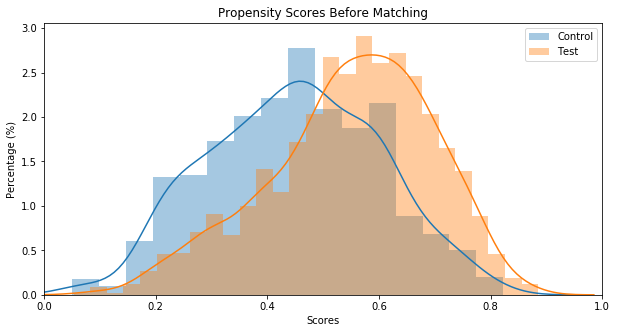

In [68]:
m.predict_scores()
m.plot_scores()

It is very clear that this model is not well-balanced in my first model. Some confounding covariates such as race, education, income, if this child is first born, mom’s score on the armed forces qualifying test, weeks per-term, didn’t satisfy the criteria. Thus, I tried to add some squared terms such as mom’s score on the armed forces qualifying test squared, weeks per-term squared, and interaction between mom’s education and family income.


In [70]:
df['momage2'] = df['momage'] * df['momage'] 
df['afqt2'] = df['afqt'] * df['afqt']
df['preterm2'] = df['preterm'] * df['preterm'] 
df['inc_edu'] = df['lnfinc_a0'] * df['momed']

In [71]:
df3= df[['first','hispanic', 'black' ,'white', 'momrace', 'female', 'hs' ,'b_marr', 'pr0', 'lths', 'momed', 'lnfinc_a0', 'brthwt', 'brorddum2', 'preterm', 'afqt', 'ltcoll', 'college', 'momage', 'age', 'rmomwk', 'afqt2', 'preterm2', 'inc_edu']]


test2 = df3[df3['first']==1]
control2 = df3[df3['first']==0]

In [72]:
m2 = Matcher(test2, control2, yvar="first")

Formula:
first ~ hispanic+black+white+momrace+female+hs+b_marr+pr0+lths+momed+lnfinc_a0+brthwt+brorddum2+preterm+afqt+ltcoll+college+momage+age+rmomwk+afqt2+preterm2+inc_edu
n majority: 2286
n minority: 814


In [73]:
np.random.seed(20170925)
m2.fit_scores(balance=True, nmodels=100)

Fitting Models on Balanced Samples: 100\100
Average Accuracy: 64.52%


looks like the first one is slightly better

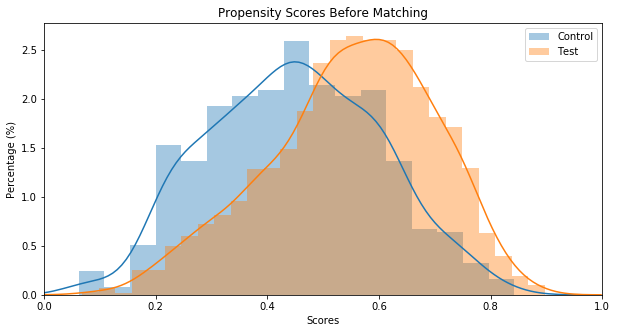

In [74]:
m2.predict_scores()
m2.plot_scores()

By eyeballing this graph, I think the overlap is sufficient. But for higher propensity score, the counterfactual unit might not be sufficient without replacement.


## Check Assumptions
* Sufficient overlap
    - This assumption I would say we meet it sufficiently from above graph.
* Ignorability
    - This is hard to say. We cannot tell from given information. You have to control for all the confounders to achieve this assumption, which is not plausible. 
* Appropriate specification of the propensity score
    - I think the overall is close balanced. So I would say this assumption is achieved.
* SUTVA
    - This is hard to say. We cannot tell from this given information. This could depend on how data were collected. It could happen that two mothers are not independent.

In [103]:
from causalinference import CausalModel
X= df[['hispanic', 'black' ,'white', 'momrace', 'female', 'hs' ,'b_marr', 'pr0', 'lths', 'momed', 'lnfinc_a0', 'brthwt', 'brorddum2', 'preterm', 'afqt', 'ltcoll', 'college', 'momage', 'age', 'rmomwk']]
y= df['piatm56']
D= df['first']

X=np.asarray(X)
causal = CausalModel(Y, D, X)

In [95]:
causal.est_propensity_s()

In [101]:
causal.est_via_weighting()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/causalinference/estimators/weighting.py:23: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  wlscoef = np.linalg.lstsq(Z_w, Y_w)[0]


In [102]:
print(causal.estimates)


Treatment Effect Estimates: Weighting

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE     -1.340      0.580     -2.309      0.021     -2.477     -0.203



### Without Matching:

In [104]:
import sklearn.linear_model as skl_lm

# Regression coefficients (Ordinary Least Squares)
regr = skl_lm.LinearRegression()

X= df[['first','hispanic', 'black' ,'white', 'momrace', 'female', 'hs' ,'b_marr', 'pr0', 'lths', 'momed', 'lnfinc_a0', 'brthwt', 'brorddum2', 'preterm', 'afqt', 'ltcoll', 'college', 'momage', 'age', 'rmomwk']]
y= df['piatm56']


regr.fit(X,y)
print(regr.intercept_)
print(regr.coef_)

89.45701170704238
[-1.27543361e+00  5.76854234e-02 -1.02420248e+00  9.66517058e-01
  9.08831635e-01  1.37525429e+00 -1.36523708e-01 -9.58353810e-01
 -2.15163602e-01 -1.37980194e-01  1.20090953e+00  8.79816711e-01
 -4.81996609e-03 -1.66043007e+00 -2.37044830e-01  1.66802906e-01
 -5.13921535e-01  7.88425437e-01 -4.09168869e-02  1.06160075e-03
 -3.80822148e-01]


The coefficient on the first variable is -1.28 with standard deviation 0.52, which is statistically significant. The math score of children whose mom goes to work in the first year after giving birth is 1.28 on average less than children whose mom does not go to work in the first year of giving birth.



This analysis did not control for the weight. The sufficient overlap assumption and Appropriate specification of the propensity score assumption probably don’t hold here because this analysis is not matched and balanced. 



# Codebook

The NLSY (National Longitudinal Survey of Youth) has been collecting information on the same cohort of men and women since 1979 when they were teenagers.  Data was collected every year until 1992 and has been collected every two years since.  The sampling was done in such a way as to be nationally representative of that age cohort at the time the study was started.  The children of women in the study have been surveyed and tested every two years since 1986 as well.  The sample you have access to represents a selection of the variables for a (nonrandom) subset of these mothers and children.  

## description of variables

### hispanic, black, white
are dummy variables for mother's ethnicity
### momrace (1=hispanic, 2=black, 3=white/other)
### female
(1=female, 0=male)
### b_marr
mom married at birth? (1=yes)
### pr0
dummy for whether the household was in poverty in the year
before the child was born (1=yes)
### momed
mom's education level when she gave birth
(1= less than hs, 2=hs grad, 3=some college, 4=finished college)
#lths, hs, ltcoll, college are the corresponding dummies

### lnfinc_a0
logged family income, scaled by the poverty rate, in the year before the child was born

### age
child's age (in months) on 1/1/1990

### momage
age of mom when she gave birth (in years)

### afqt
mom's score on the armed forces qualifying test (an iq test of sorts)

### brthwt
birthweight of child in oz

### brorddum
1 if child first born, 0 otherwise

### preterm
weeks pre-term (note that if born late this could be negative)
all the ihdp kids were preterm

### rmomwk
did respondent (mother of child) have a mom who worked when 
respondent was in high school? (1=yes)

### work
1=mom did not work in 1st 3 years of child's life
2=mom did not work in 1st year of child's life but did work sometime
  in years 2 or 3
3=mom worked part-time in child's first year of life
4=mom worked full-time in child's first year of life

### ppvt
score on the Peabody Picture Vocab. Test (Revised) at 36 months
(a form of IQ test)

### piatm56
score on the PIAT math component at age 5 or 6
(a form of IQ test)

### piatr56
score on the PIAT reading component at age 5 or 6
(a form of IQ test)

### piatm78
score on the PIAT math component at age 7 or 8
(a form of IQ test)

### piatr78
score on the PIAT reading component at age 7 or 8
(a form of IQ test)
